In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    #sigma = 0.33
    #v = np.median(img)
 
    # apply automatic Canny edge detection using the computed median
    #lower = int(max(0, (1.0 - sigma) * v))
    #upper = int(min(255, (1.0 + sigma) * v))
    #return cv2.Canny(img, lower, upper)
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=7):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
         
    for line in lines:
        for x1,y1,x2,y2 in line:
            alpha = math.atan2(y2-y1,x2-x1)
            x0 = int(round(x1 - 250 * math.cos(alpha)))
            y0 = int(round(y1 - 250 * math.sin(alpha)))
            cv2.line(img, (x1, y1), (x0, y0), color, thickness)
    """
    #Define different arrays and initialize y_min and y_max
    right_slope=[]
    right_x=[]
    right_y=[]
    left_slope=[]
    left_x=[]
    left_y=[]
    y_min=320
    y_max=img.shape[0]
    
    #Calculate slope and assign them to left/right side
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                #identify global minimum y
                if y1<y_min:
                    y_min=y1
                #Calculate slope and assign it likewise
                slope= (y2-y1)/(x2-x1)
                if slope<=-0.4 and slope >=-0.88:
                    left_slope.append(slope)
                    left_x.append(x1)
                    left_x.append(x2)
                    left_y.append(y1)
                    left_y.append(y2)
                elif slope>=0.2 and slope<=0.88:
                    right_slope.append(slope)
                    right_x.append(x1)
                    right_x.append(x2)
                    right_y.append(y1)
                    right_y.append(y2)
    rdrawn = False
    
    if right_slope:
        #Averaging the position of line segment right side
        avg_right_slope= np.median(right_slope)#sum(right_slope)/float(len(right_slope))
        avg_right_x=np.average(right_x)#sum(right_x)/float(len(right_x))
        avg_right_y=np.average(right_y)#sum(right_y)/float(len(right_y))
        #Calculate intercept for averaged right coordinates
        #print('rigth average is', avg_right_slope, right_slope)
        right_intercept= avg_right_y-(avg_right_slope*avg_right_x)
        #Find x1,x2 for highest point, we already have y1,y2
        x1_right=(y_min-right_intercept)/avg_right_slope
        x2_right=(y_max-right_intercept)/avg_right_slope
        #Draw right line
        cv2.line(img, (int(x1_right), y_min), (int(x2_right), y_max), color, thickness)
        rdrawn = True
    
    if left_slope:
        #Averaging the position of line segment left side
        avg_left_slope= np.median(left_slope)#sum(left_slope)/float(len(left_slope))
        
        avg_left_x=sum(left_x)/float(len(left_x))
        avg_left_y=sum(left_y)/float(len(left_y))
        #Calculate intercept for averaged left coordinates
        left_intercept= avg_left_y-(avg_left_slope*avg_left_x)
        #Find x1,x2 for highest point, we already have y1,y2
        if avg_left_slope != 0:
            x1_left=(y_min-left_intercept)/avg_left_slope
            x2_left=(y_max-left_intercept)/avg_left_slope
            #Draw left line
            cv2.line(img, (int(x1_left), y_min), (int(x2_left), y_max), color, thickness)
            # average left and right slopes


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


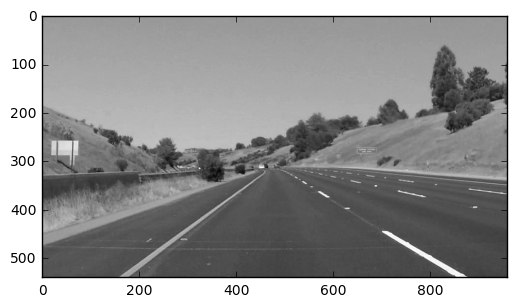

In [14]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
#plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
plt.imshow(grayscale(image),cmap='gray')

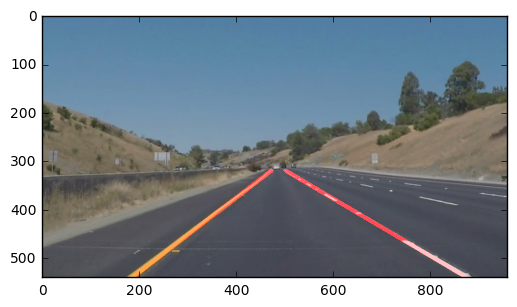

In [15]:
import os
images = os.listdir("test_images/")

def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    #print('This image is:', type(image), 'with dimesions:', image.shape)
    #with kernal size 5
    r = 960.0 / img.shape[1]
    dim = (960, int(img.shape[0] * r))
 
    # perform the actual resizing of the image and show it
    image = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    #print("resized" , image.shape)
    #plt.imshow(grayscale(image))
    blur_gray = gaussian_blur(grayscale(image),9)
    #thrashold with 50 and 150
    edges = canny(blur_gray,40,150) 

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    #print(imshape)
    #vertices = np.array([[(0,imshape[0]),(450, 315), (490, 315), (imshape[1],imshape[0])]], dtype=np.int32)
    vertices = np.array([[(150,imshape[0]),(410, 350),(580, 350), (imshape[1],imshape[0])]], dtype=np.int32)
    
    masked_edges = region_of_interest(edges,vertices)
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell) 15
    min_line_length = 15 #minimum number of pixels making up a line
    max_line_gap = 100   # maximum gap in pixels between connectable line segments
    #line_image = np.copy(image)*0 # creating a blank to draw lines on
    line_image = hough_lines(masked_edges,rho,theta,threshold,min_line_length, max_line_gap)
    mm_line_images = region_of_interest(line_image,vertices)
    color_edges = np.dstack((edges, edges, edges)) 
    #lines_edges = weighted_img(line_image,color_edges)
    lines_edges = weighted_img(line_image,image)
    #mpimg.imsave("test_images/after-"+img,lines_edges)
    plt.imshow(lines_edges)
    
    return lines_edges

for img in images:
    image= mpimg.imread("test_images/"+img)
    process_image(image)
    

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 36.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 5.2 s, sys: 391 ms, total: 5.59 s
Wall time: 6.53 s


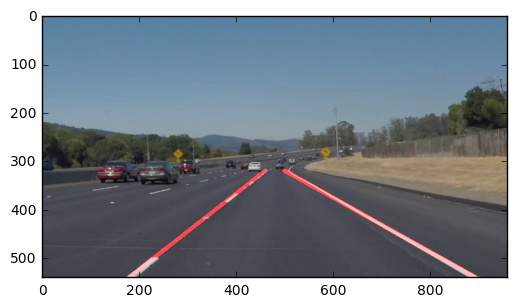

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:20<00:00, 34.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 16.3 s, sys: 2.12 s, total: 18.4 s
Wall time: 20.4 s


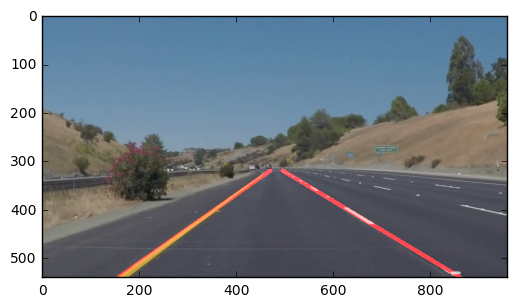

In [17]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

#HTML("""
#<video width="960" height="540" controls>
#  <source src="{0}">
#</video>
#""".format(yellow_output))

## Reflections
Congratulations on finding the lane lines! As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust? Where will your current algorithm be likely to fail?
Please add your thoughts below, and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!
### ..
Right now my code relies on Grayscale transformation of individual frames for line detection, using multiple frames for line reference would likely make it more accurate when there are erroneous detections. It may be possible that using other color channels like HSV etc to detect yellow line much more and then merge with the final image before hough line.  
Still few places the lines disappers, due to incorrect slope, which could be improved.

My current method of detecting lane lines takes all of the points, separates them based on the side of the road, and eliminates lines with an inappropriate slope. This method works well when the lines are straight, clearly marked against a dark background, and the image contains no other (or few) additional objects or markings in the masked section of the image. This means that in a situation like the extra(challenge) video, when there is a transition from asphalt to concrete the current pipeline doesnt know how to handle the extra information.Changing the color channel migh help, There is also an issue with the lower section of the image containing the hood of the car. This pipeline is also only accurate with straight lines, curved lines will throw off the current method of fitting a straight best fit line do the data points.

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:09<00:00, 21.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 8.98 s, sys: 1.01 s, total: 9.99 s
Wall time: 9.95 s


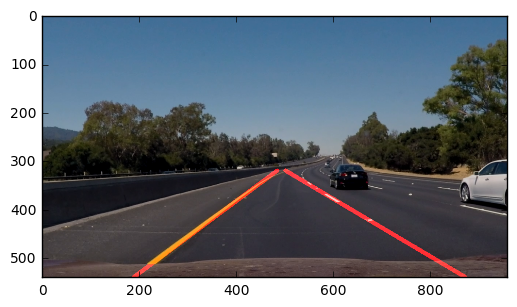

In [18]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)